In [ ]:
# @title Import Requirements
import os
import io
import gc
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tqdm.notebook import tqdm
from IPython.display import clear_output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification
)
from transformers.activations_tf import ACT2FN

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
 try:
  tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  tf.config.experimental.set_memory_growth(gpus[0], True)
  print(gpus[0])
 except RuntimeError as e:
  print(e)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
fdir = './NLP/Data/SentEval/data/probing/'

BATCH_SIZE = 256
MAX_LENGTH = 64
no_examples = 9996

TASK_NAME = 'obj_number.txt'

CLASSIFIER_MODEL_FPATH = './NLP/Models/SentEvalAnalysis/BERT_AVG_Classifiers/'

pretrained_loc = "bert-base-uncased"
print("Running with:", pretrained_loc)

Running with: bert-base-uncased


In [ ]:
# @title Required Functions & Classes
def load_probing_data(fpath, additive=''):
    task_data = {'train': {'X': [], 'y': []},
                 'dev': {'X': [], 'y': []},
                 'test': {'X': [], 'y': []}}


    tok2split = {'tr': 'train', 'va': 'dev', 'te': 'test'}
    with io.open(fpath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip().split('\t')
            task_data[tok2split[line[0]]]['X'].append(additive + line[-1])
            task_data[tok2split[line[0]]]['y'].append(line[1])

        if fpath == '/home/username/SentEval/data/probing/tree_depth.txt':
            labels = ['5', '6', '7', '8', '9', '10', '11']
            tok2label = dict(zip(labels, [0, 1. / 6, 2. / 6, 3. / 6, 4. / 6, 5. / 6, 1]))
        else:
            labels = sorted(np.unique(task_data['train']['y']))
            tok2label = dict(zip(labels, range(len(labels))))
        nclasses = len(tok2label)

        for split in task_data:
            for i, y in enumerate(task_data[split]['y']):
                task_data[split]['y'][i] = tok2label[y]

    return task_data, tok2label, nclasses

class BertReprProbing(tf.keras.Model):
    def __init__(self, bert_model, **kwargs):
        super(BertReprProbing, self).__init__(name="BertReprProbing")
        self.bert = bert_model

    def call(self, inputs, **kwargs):
        middle_hidden_states = self.bert(inputs, **kwargs)[2]
        output = []
        for i in range(1, 13):
            output.append(middle_hidden_states[i])
        return tf.stack(output)

from IPython.display import HTML
import matplotlib.cm as cm
import matplotlib.colors as clr

def visualize_attention(sentences, score_lists, color_maps='Greens',
                        alpha=0.5, font_size=14, token_sep=' ', sentence_sep='<br/><br/>'):

  if type(color_maps) is str:
    color_maps = [color_maps] * len(sentences)

  span_sentences, style_sentences = [], []

  for s, tokens in enumerate(sentences):

    scores = score_lists[s]
    cmap = cm.get_cmap(color_maps[s])
    
    off = (sum(scores) / len(scores)) * alpha
    normer = clr.Normalize(vmin=min(scores)-off, vmax=max(scores)+off)
    colors = [clr.to_hex(cmap(normer(x))) for x in scores]

    if len(tokens) != len(colors):
        raise ValueError("number of tokens and colors don't match")

    style_elems, span_elems = [], []
    for i in range(len(tokens)):
        style_elems.append(f'.c{s}-{i} {{ background-color: {colors[i]}; }}')
        span_elems.append(f'<span class="c{s}-{i}">{tokens[i]} </span>')

    span_sentences.append(token_sep.join(span_elems))
    style_sentences.append(' '.join(style_elems))

  return HTML(f"""<html><head><link href="https://fonts.googleapis.com/css?family=Roboto+Mono&display=swap" rel="stylesheet">
               <style>span {{ font-family: "Roboto Mono", monospace; font-size: {font_size}px; }} {' '.join(style_sentences)}</style>
               </head><body>{sentence_sep.join(span_sentences)}</body></html>""")

@tf.function
def tf_average(hidden_states, att_mask, w):
  max_length = tf.cast(tf.shape(att_mask)[1], tf.float32)
  att_mask = tf.cast(att_mask[:, 1:], tf.float32)
  avg = tf.reshape(tf.matmul(tf.transpose(hidden_states[:, 1:] * tf.expand_dims(att_mask, axis=-1), perm=[0, 2, 1]), w), (-1, 768))
  avg = avg * tf.cast((max_length - 1.0) / tf.reduce_sum(att_mask, axis=-1, keepdims=True), tf.float32)
  return avg

In [ ]:
# @title Load BERT Model
config = BertConfig.from_pretrained(pretrained_loc, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loaded_model = TFBertForSequenceClassification.from_pretrained(pretrained_loc,
                                                               config=config)

probing_model = BertReprProbing(loaded_model.bert)
clear_output()
print("Done!")

Done!


In [ ]:
# @title Probe Feature Extraction
probe_path = fdir + TASK_NAME
task_data, tok2label, nclasses = load_probing_data(probe_path)
print("Probe Loaded:", TASK_NAME)

steps = int(np.ceil(no_examples / BATCH_SIZE))

# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
# temp = list(zip(task_data['test']['X'], task_data['test']['y']))
# random.shuffle(temp)
# task_data['test']['X'], task_data['test']['y'] = zip(*temp)
task_data['test']['y'] = np.array(task_data['test']['y'][:no_examples])

### Free some RAM!!!
# del temp
del task_data['train']
del task_data['dev']
gc.collect()

hidden_representations = np.zeros((12, no_examples, MAX_LENGTH, 768), dtype=np.float32)
token_ids = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)
att_masks = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)

print("Starting probe feature extraction:", TASK_NAME)

for i in tqdm(range(steps)):
    tokens_batched = tokenizer.batch_encode_plus(task_data['test']['X'][i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, no_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='tf',
                                                 truncation=True,
                                                 pad_to_max_length=True)

    hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()
                                                             
    att_masks[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['attention_mask']
    token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['input_ids']

In [ ]:
# @title Importance Computation
saliances = np.zeros((12, nclasses, no_examples, MAX_LENGTH))

weights = tf.Variable(np.ones((MAX_LENGTH-1, 1)) / (MAX_LENGTH-1), dtype=tf.float32, trainable=True)

BATCH_SIZE = 128
steps = int(np.ceil(no_examples / BATCH_SIZE))

for i in range(12):
    print("Load classifier", i)
    classifier = tf.keras.models.load_model(CLASSIFIER_MODEL_FPATH + TASK_NAME[:-4] + '/' + str(i))
    acc = 0.0
    for j in tqdm(range(steps)):
        with tf.GradientTape() as tape:
            avgs = tf_average(hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :],
                              att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], weights)
            probs = classifier(avgs)
            sing_probs = probs[:, 0]
        grads = tape.gradient(sing_probs, avgs)
        salience_scores = tf.expand_dims(grads, axis=1) * hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :] * tf.cast(tf.expand_dims(att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], axis=-1), dtype=tf.float32)

        saliances[i][0][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1:] = tf.reduce_sum(salience_scores[:, 1:, :], axis=-1).numpy()
        saliances[i][1][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1:] = - saliances[i][0][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1:]

        acc += np.mean(tf.argmax(probs, axis=-1).numpy() == task_data['test']['y'][j * BATCH_SIZE:(j + 1) * BATCH_SIZE])
    print(acc / steps)

Load classifier 0



0.8209388185654009
Load classifier 1



0.8306302742616034
Load classifier 2



0.842002900843882
Load classifier 3



0.8512658227848101
Load classifier 4



0.8603968881856541
Load classifier 5



0.8601661392405063
Load classifier 6



0.8608583860759493
Load classifier 7



0.8558148734177216
Load classifier 8



0.8490901898734177
Load classifier 9



0.8382120253164557
Load classifier 10



0.8330036919831224
Load classifier 11



0.8271690400843883


In [ ]:
# @title Post Processing
unique_tokens, token_inverse, token_counts = np.unique(token_ids, return_counts=True, return_inverse=True)

gold_importance = np.empty((12, no_examples, MAX_LENGTH))
for i in range(no_examples):
  gold_importance[:, i] = saliances[:, task_data['test']['y'][i], i]

### Token-based Analysis

In [ ]:
import matplotlib as mpl
 
mpl.rcParams['axes.linewidth'] = 1.7 #set the value globally

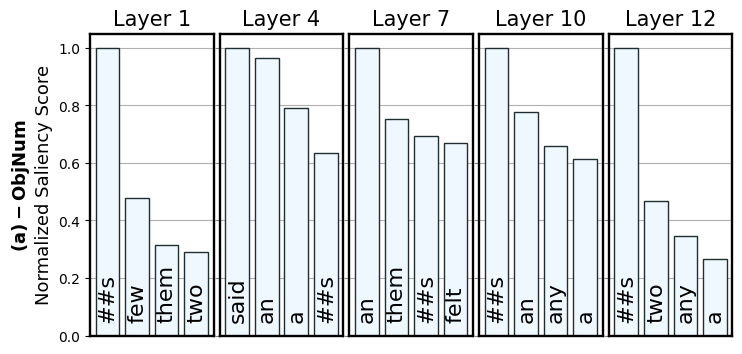

In [ ]:
# @title Top words importance - ABSOLUTE
TOP_TOKENS_TO_SHOW = 4

import matplotlib

fig = plt.figure(figsize = (20,4), dpi=100)
fig.subplots_adjust(wspace=0.05)
top_tokens = np.argwhere(token_counts > 128)[2:].flatten()
cmap = matplotlib.cm.get_cmap('summer')

top_imps = []
for l_idx, layer_num in enumerate([0, 3, 6, 9, 11]):
  top_tokens_importances = []
  for i in top_tokens:
    mean_imp = np.mean(gold_importance[layer_num][token_ids == unique_tokens[i]])
    top_tokens_importances.append(mean_imp)
  
  labels = []
  imps = []
  top_tokens_importances = np.array(top_tokens_importances)
  top_imps.append(top_tokens_importances)
  for i in reversed(np.argsort(top_tokens_importances)[-TOP_TOKENS_TO_SHOW:]):
    labels.append(tokenizer.decode([unique_tokens[top_tokens[i]]]))
    imps.append(top_tokens_importances[i])

  ax = fig.add_subplot(1, 12, l_idx+1, fc='#FFFFFF')
  ax.grid('on', axis='y')
  ax.set_axisbelow(True)
  ax.bar(np.arange(TOP_TOKENS_TO_SHOW), imps / np.max(imps), align='center', color='aliceblue', edgecolor='#1f2e2e', linewidth=1)
  for i, (p, pr) in enumerate(zip(labels, imps / np.max(imps))):
    y_base = (pr + 0.05 if pr < 0.22 else 0.06)
    color = 'k'
    ax.text(s=p, x=i+0.03-TOP_TOKENS_TO_SHOW/11, y=y_base, color=color, size=16, rotation=90, weight='normal')
  ax.set_xticks([])
  if l_idx != 0:
    ax.tick_params(axis='y', colors='gray')
    ax.set_yticklabels([])
  else:
    ax.set_ylabel(r"$\bf{(a) - ObjNum}$"+"\nNormalized Saliency Score", size=13)
  ax.set_title('Layer ' + str(layer_num + 1), size=15)
  # ax.set(frame_on=False)

# fig.tight_layout()
plt.show()